# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession, Window
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import udf, isnan, avg, asc, max, count, col
from pyspark.sql.functions import sum as Fsum

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from time import time
import numpy as np

In [2]:
# create a Spark session
spark = SparkSession.builder.master("local").appName("Sparkify").getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
mini_sparkify_data = spark.read.json('mini_sparkify_event_data.json')

In [4]:
mini_sparkify_data.count()

286500

In [5]:
mini_sparkify_data.describe()

DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string]

In [6]:
mini_sparkify_data.show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|    Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Bost

### Drop Rows with Missing Values

In [7]:
for coln in mini_sparkify_data.columns:
    missing_count = mini_sparkify_data.filter((isnan(mini_sparkify_data[coln])) | (mini_sparkify_data[coln].isNull()) | (mini_sparkify_data[coln] == "")).count()
    print(coln, ": ", missing_count)

artist :  58392
auth :  0
firstName :  8346
gender :  8346
itemInSession :  0
lastName :  8346
length :  58392
level :  0
location :  8346
method :  0
page :  0
registration :  8346
sessionId :  0
song :  58392
status :  0
ts :  0
userAgent :  8346
userId :  8346


In [8]:
#Dropping rows that have missing userId
df = mini_sparkify_data.dropna(how = "any", subset = ["userId"])
df = df.filter(df["userId"] != "")

In [9]:
df.count()

278154

In [10]:
df.select('page').dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [11]:
df.select('level').dropDuplicates().show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

### Churn Definition

In [12]:
#Adding "Churn" column based on "Cancellation Confirmation"

is_churn = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
df = df.withColumn("Churn", is_churn("page"))
df.show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|Churn|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|    0|
|    Five Iron Frenzy|Logged In|    Micah|     M|           79|    L

In [13]:
# Calculating percentage of users who churned
percent_users_churned = df.groupBy('userId').agg({'Churn': 'sum'}).select(avg('sum(Churn)')).collect()[0]['avg(sum(Churn))']
print(f"{round(percent_users_churned*100)}% users have churned.")

23% users have churned.


In [14]:
# Calculating churn flag at final timestamps
windowval = Window.partitionBy("userId").orderBy(asc("ts")).rangeBetween(Window.unboundedPreceding, 0)
df = df.withColumn("churnUser", max('Churn').over(Window.partitionBy("userId")))

In [15]:
df.show()

+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+---------+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|       page| registration|sessionId|                song|status|           ts|           userAgent|userId|Churn|churnUser|
+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+---------+
|Sleeping With Sirens|Logged In| Darianna|     F|            0|Carpenter|202.97098| free|Bridgeport-Stamfo...|   PUT|   NextSong|1538016340000|       31|Captain Tyin Knot...|   200|1539003534000|"Mozilla/5.0 (iPh...|100010|    0|        0|
|Francesca Battist...|Logged In| Dariann

Text(0,0.5,'Churn rate')

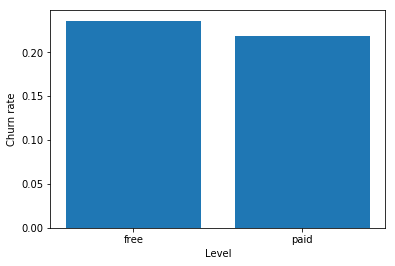

In [16]:
# Visualize level patterns
levels = df.select(['userId', 'level', 'churnUser']).dropDuplicates().groupBy('level').agg(count('userId').alias('num_users'), Fsum('churnUser').alias('num_churns'))
levels_df = levels.toPandas()

plt.bar(levels_df['level'], levels_df['num_churns'] / levels_df['num_users'])
plt.xlabel("Level")
plt.ylabel("Churn rate")

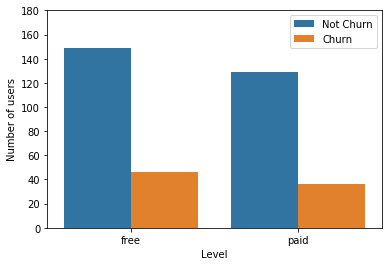

In [17]:
# Visualize the number of users by level
func_churn_label = udf(lambda x: 'Churn' if x == 1 else 'Not Churn')
level_users_pd = df.select(['userId', 'level', 'churnUser']).dropDuplicates().withColumn('churnUser', func_churn_label('churnUser')).toPandas()

sns.countplot(x="level", hue="churnUser", data=level_users_pd)
plt.ylim(0, 180)
plt.xlabel("Level")
plt.ylabel("Number of users")
plt.legend(loc='best')

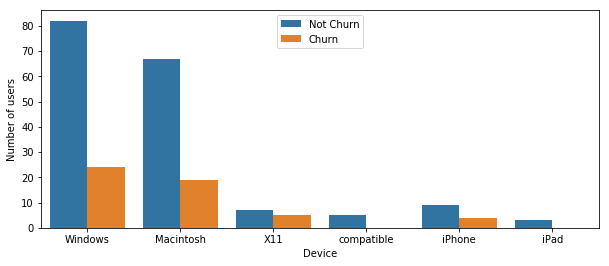

In [18]:
# Calculate churns by device
func_churn_label = udf(lambda x: 'Churn' if x == 1 else 'Not Churn')
func_agent_device = udf(lambda x: x.split('(')[1].replace(";", " ").split(" ")[0])

df_sub_device = df.withColumn("userAgent", func_agent_device(df["userAgent"]))
device_pd = df_sub_device.select(["userId", 'userAgent', 'churnUser']).dropDuplicates().withColumn('churnUser', func_churn_label('churnUser')).toPandas()

fig = plt.figure(figsize=(10, 4))
sns.countplot(x="userAgent", hue="churnUser", data=device_pd)
plt.xlabel("Device")
plt.ylabel("Number of users")
plt.legend(loc='best')

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [19]:
# Time since registration
temp = df.select('userId','registration','ts').withColumn('lifetime',(df.ts-df.registration)).groupBy('userId').agg({'lifetime':'max'}).withColumnRenamed('max(lifetime)','time_since_registration')
feature_1 = temp.select('userId', (col('time_since_registration')/1000/3600/24).alias('time_since_registration'))

feature_1.describe().show()

+-------+------------------+-----------------------+
|summary|            userId|time_since_registration|
+-------+------------------+-----------------------+
|  count|               225|                    225|
|   mean|65391.013333333336|       79.8456834876543|
| stddev|105396.47791907164|      37.66147001861254|
|    min|                10|    0.31372685185185184|
|    max|                99|      256.3776736111111|
+-------+------------------+-----------------------+



In [20]:
# Number of songs listened

feature_2 = df.select('userID','song').groupBy('userID').count().withColumnRenamed('count', 'num_songs')
feature_2.describe().show()

+-------+------------------+-----------------+
|summary|            userID|        num_songs|
+-------+------------------+-----------------+
|  count|               225|              225|
|   mean|65391.013333333336|          1236.24|
| stddev|105396.47791907164|1329.531716432519|
|    min|                10|                6|
|    max|                99|             9632|
+-------+------------------+-----------------+



In [21]:
# Number of Thumbs-Up

feature_3 = df.select('userID','page').where(df.page == 'Thumbs Up').groupBy('userID').count().withColumnRenamed('count', 'num_thumbs_up')
feature_3.describe().show()

+-------+------------------+-----------------+
|summary|            userID|    num_thumbs_up|
+-------+------------------+-----------------+
|  count|               220|              220|
|   mean| 66420.27727272727|            57.05|
| stddev|106196.51156121881|65.67028650524044|
|    min|                10|                1|
|    max|                99|              437|
+-------+------------------+-----------------+



In [22]:
# Number of Thumbs-Down

feature_4 = df.select('userID','page').where(df.page == 'Thumbs Down').groupBy('userID').count().withColumnRenamed('count', 'num_thumbs_down')
feature_4.describe().show()

+-------+------------------+------------------+
|summary|            userID|   num_thumbs_down|
+-------+------------------+------------------+
|  count|               203|               203|
|   mean| 66066.16256157635|12.541871921182265|
| stddev|106108.32569893777|13.198108566983787|
|    min|                10|                 1|
|    max|                99|                75|
+-------+------------------+------------------+



In [23]:
# Number of songs added to playlist

feature_5 = df.select('userID','page').where(df.page == 'Add to Playlist').groupBy('userID').count().withColumnRenamed('count', 'num_playlist')
feature_5.describe().show()

+-------+------------------+-----------------+
|summary|            userID|     num_playlist|
+-------+------------------+-----------------+
|  count|               215|              215|
|   mean| 66103.63720930232|30.35348837209302|
| stddev|106360.47999565038| 32.8520568555997|
|    min|                10|                1|
|    max|                99|              240|
+-------+------------------+-----------------+



In [24]:
# Number of friends added
feature_6 = df.select('userID','page').where(df.page == 'Add Friend').groupBy('userID').count().withColumnRenamed('count', 'num_add_friend') 
feature_6.describe().show()

+-------+------------------+------------------+
|summary|            userID|    num_add_friend|
+-------+------------------+------------------+
|  count|               206|               206|
|   mean| 66076.91262135922|20.762135922330096|
| stddev|106860.60517425007|20.646779074405007|
|    min|                10|                 1|
|    max|                99|               143|
+-------+------------------+------------------+



In [25]:
# Total time listening to music
feature_7 = df.select('userID','length').groupBy('userID').sum().withColumnRenamed('sum(length)', 'listen_time')
feature_7.describe().show()

+-------+------------------+------------------+
|summary|            userID|       listen_time|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336|252558.32065155543|
| stddev|105396.47791907164| 275396.4038847635|
|    min|                10|         691.66884|
|    max|                99|1991154.9155799907|
+-------+------------------+------------------+



In [26]:
# Number of songs played per session
feature_8 = df.where('page == "NextSong"').groupby(['userId', 'sessionId']).count().groupby(['userId']).agg({'count':'avg'}).withColumnRenamed('avg(count)', 'songs_per_session')
feature_8.describe().show()

+-------+------------------+-----------------+
|summary|            userId|songs_per_session|
+-------+------------------+-----------------+
|  count|               225|              225|
|   mean|65391.013333333336|70.78971233958933|
| stddev|105396.47791907164| 42.6153697543817|
|    min|                10|              3.0|
|    max|                99|286.6666666666667|
+-------+------------------+-----------------+



In [27]:
# Gender
feature_9 = df.select("userId", "gender").dropDuplicates().replace(['M', 'F'], ['1', '0'], 'gender').select('userId', col('gender').cast('int'))
feature_9.describe().show()

+-------+------------------+-------------------+
|summary|            userId|             gender|
+-------+------------------+-------------------+
|  count|               225|                225|
|   mean|65391.013333333336| 0.5377777777777778|
| stddev|105396.47791907165|0.49968243883744773|
|    min|                10|                  0|
|    max|                99|                  1|
+-------+------------------+-------------------+



In [28]:
# Number of unique artists listened
feature_10 = df.filter(df.page=="NextSong").select("userId", "artist").dropDuplicates().groupby("userId").count().withColumnRenamed("count", "unique_artists")
feature_10.describe().show()

+-------+------------------+-----------------+
|summary|            userId|   unique_artists|
+-------+------------------+-----------------+
|  count|               225|              225|
|   mean|65391.013333333336|696.3777777777777|
| stddev|105396.47791907164|603.9518698630802|
|    min|                10|                3|
|    max|                99|             3544|
+-------+------------------+-----------------+



In [29]:
label = df.select('userId', col('churnUser').alias('label')).dropDuplicates()
label.describe().show()

+-------+------------------+------------------+
|summary|            userId|             label|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336|0.2311111111111111|
| stddev|105396.47791907164|0.4224832108996327|
|    min|                10|                 0|
|    max|                99|                 1|
+-------+------------------+------------------+



In [30]:
final_data = feature_1.join(feature_2,'userID','outer')
final_data = final_data.join(feature_3,'userID','outer')
final_data = final_data.join(feature_4,'userID','outer')
final_data = final_data.join(feature_5,'userID','outer')
final_data = final_data.join(feature_6,'userID','outer')
final_data = final_data.join(feature_7,'userID','outer')
final_data = final_data.join(feature_8,'userID','outer')
final_data = final_data.join(feature_9,'userID','outer')
final_data = final_data.join(feature_10,'userID','outer')
final_data = final_data.join(label,'userID','outer')
final_data = final_data.drop('userID').fillna(0)
final_data.show(5)

+-----------------------+---------+-------------+---------------+------------+--------------+------------------+------------------+------+--------------+-----+
|time_since_registration|num_songs|num_thumbs_up|num_thumbs_down|num_playlist|num_add_friend|       listen_time| songs_per_session|gender|unique_artists|label|
+-----------------------+---------+-------------+---------------+------------+--------------+------------------+------------------+------+--------------+-----+
|       55.6436574074074|      381|           17|              5|           7|             4| 66940.89735000003|39.285714285714285|     0|           252|    0|
|      70.07462962962963|      474|           21|              6|           8|             4| 94008.87593999993|              64.5|     1|           339|    0|
|      71.31688657407408|       11|            0|              0|           0|             0|2089.1131000000005|               8.0|     1|             8|    1|
|     131.55591435185184|     4825|     

In [31]:
final_data.columns

['time_since_registration',
 'num_songs',
 'num_thumbs_up',
 'num_thumbs_down',
 'num_playlist',
 'num_add_friend',
 'listen_time',
 'songs_per_session',
 'gender',
 'unique_artists',
 'label']

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [32]:
# Vector assembler needed for pyspark
cols = ['time_since_registration',
 'num_songs',
 'num_thumbs_up',
 'num_thumbs_down',
 'num_playlist',
 'num_add_friend',
 'listen_time',
 'songs_per_session',
 'gender',
 'unique_artists']
assembler = VectorAssembler(inputCols=cols, outputCol="features")
data = assembler.transform(final_data)

# # standard scaler
# scaler = StandardScaler(inputCol="NumFeatures", outputCol="features", withStd=True)
# scalerModel = scaler.fit(data)
# data = scalerModel.transform(data)

In [33]:
data.show()

+-----------------------+---------+-------------+---------------+------------+--------------+------------------+------------------+------+--------------+-----+--------------------+
|time_since_registration|num_songs|num_thumbs_up|num_thumbs_down|num_playlist|num_add_friend|       listen_time| songs_per_session|gender|unique_artists|label|            features|
+-----------------------+---------+-------------+---------------+------------+--------------+------------------+------------------+------+--------------+-----+--------------------+
|       55.6436574074074|      381|           17|              5|           7|             4| 66940.89735000003|39.285714285714285|     0|           252|    0|[55.6436574074074...|
|      70.07462962962963|      474|           21|              6|           8|             4| 94008.87593999993|              64.5|     1|           339|    0|[70.0746296296296...|
|      71.31688657407408|       11|            0|              0|           0|             0|20

In [34]:
# train test split
train, _temp = data.randomSplit([0.6, 0.4], seed=42)
val, test = _temp.randomSplit([0.5, 0.5], seed=42)

#### Logistic Regression

In [35]:
# initialize LogisticRegression classifier
lr = LogisticRegression(maxIter=10)

# initialize F1 evaluator
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

# create paramGrid
paramGrid = ParamGridBuilder().build()

# initialize cross validation pipeline
crossval_lr = CrossValidator(estimator=lr, evaluator=f1_evaluator, estimatorParamMaps=paramGrid, numFolds=3)
cvModel_lr = crossval_lr.fit(train)

In [36]:
results_lr = cvModel_lr.transform(val)
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Logistic Regression Metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(results_lr, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(results_lr, {evaluator.metricName: "f1"})))

Logistic Regression Metrics:
Accuracy: 0.7666666666666667
F-1 Score:0.7047619047619048


#### Random Forest

In [37]:
# initialize classifier
rf = RandomForestClassifier()

# build paramGrid
paramGrid = ParamGridBuilder().build()

crossval_rf = CrossValidator(estimator=rf, evaluator=f1_evaluator, estimatorParamMaps=paramGrid, numFolds=3)
cvModel_rf = crossval_rf.fit(train)

In [38]:
results_rf = cvModel_rf.transform(val)
print('Random Forest Metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(results_rf, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(results_rf, {evaluator.metricName: "f1"})))

Random Forest Metrics:
Accuracy: 0.8666666666666667
F-1 Score:0.8047619047619048


#### Gradient Boosted Trees

In [39]:
# initialize classifier
gbt = GBTClassifier(maxIter=10,seed=42)

# build paramGrid
paramGrid = ParamGridBuilder().build()

crossval_gbt = CrossValidator(estimator=gbt, evaluator=f1_evaluator, estimatorParamMaps=paramGrid, numFolds=3)
cvModel_gbt = crossval_gbt.fit(train)

In [40]:
results_gbt = cvModel_gbt.transform(val)
print('Gradient Boosted Trees Metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(results_gbt, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(results_gbt, {evaluator.metricName: "f1"})))

Gradient Boosted Trees Metrics:
Accuracy: 0.8
F-1 Score:0.7703703703703705


#### Best Model - Hyper Parameter Tuning

In [41]:
# initialize classifier
rf_tuned = RandomForestClassifier()

# build paramGrid
paramGrid = ParamGridBuilder()\
            .addGrid(rf.numTrees,[5, 10])\
            .addGrid(rf.maxDepth, [2, 4])\
            .build()

crossval_rf_tuned = CrossValidator(estimator=rf_tuned, evaluator=f1_evaluator, estimatorParamMaps=paramGrid, numFolds=3)
cvModel_rf_tuned = crossval_rf_tuned.fit(train)

In [42]:
cvModel_rf_tuned.avgMetrics

[0.7132548750125465,
 0.7132548750125465,
 0.7150164413591523,
 0.8047619047619048]

In [43]:
rf_best = RandomForestClassifier(numTrees=10, maxDepth=2)
rf_best_model = rf_best.fit(train)

In [44]:
results_final = rf_best_model.transform(test)
print('Random Forest Metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(results_final, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(results_final, {evaluator.metricName: "f1"})))

Random Forest Metrics:
Accuracy: 0.896551724137931
F-1 Score:0.8144578313253012


Text(0.5,1,'RF Feature Importances')

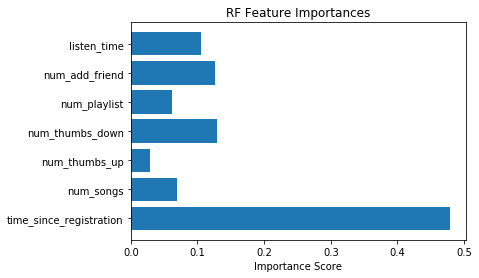

In [53]:
feat_imp = rf_best_model.featureImportances.values
y_pos = np.arange(len(feat_imp))

plt.barh(y_pos, feat_imp, align='center')
plt.yticks(y_pos, cols)
plt.xlabel('Importance Score')
plt.title('RF Feature Importances')

# Conclusion

In this notebook, we implemented a model trying to predict customer churn. We removed rows with no userId and converted gender to binary numeric column. We created 10 features to run our 3 models: Logistic Regression, Random Forest and Gradient Boosted Trees. We compared the performance of the 3 models, and selected Random Forest for our final implementation. We used cross validation and grid search to fine tune our model to achieve 89% accuracy, and 0.81 F1 score.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.